In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split


### Retrieve and Prepare Data

In [2]:
source_dir = "C:/Users/laure/Documents/proj_loopr/processed_images"
mask_dir = "C:/Users/laure/Documents/proj_loopr/all_masks"

def retrieve_images(fil_dir):
    sample_list = os.listdir(fil_dir)
    img_list = np.zeros((len(sample_list),7,40,500))
    ind = 0
    for file_name in sample_list:
        img_list[ind,:,:,:] = np.load(os.path.join(fil_dir,file_name))
        ind+=1
    return img_list

def retrieve_masks(fil_dir):
    sample_list = os.listdir(fil_dir)
    img_list = np.zeros((len(sample_list),40,500))
    ind = 0
    for file_name in sample_list:
        img_list[ind,:,:] = np.load(os.path.join(fil_dir,file_name))
        ind+=1
    return img_list.reshape(-1,1,40,500)

xs = retrieve_images(source_dir)
masks = retrieve_masks(mask_dir)

In [3]:
masks.shape

(246, 1, 40, 500)

In [4]:
def sliding_window(image, sq_size = 22, pix_steps=2):
    img_list = []
    for i in np.arange(0,image.shape[1]-sq_size+pix_steps,pix_steps):
        for j in np.arange(0,image.shape[2]-sq_size+pix_steps,pix_steps):
            img_list.append(image[:,i:i+sq_size,j:j+sq_size])
    return np.array(img_list)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(xs, masks, test_size=0.8, random_state=81)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=81)


In [6]:

def get_windowed_data(imgs, masks):
    windows_per_im = 10*240
    fin_data = np.zeros((imgs.shape[0]*windows_per_im,7,22,22))
    fin_labs = np.zeros((imgs.shape[0]*windows_per_im,1))
    for ind in range(imgs.shape[0]):
        fin_data[ind*windows_per_im:(ind+1)*windows_per_im,:,:,:] = sliding_window(imgs[ind,:,:,:])
        mask_windows = sliding_window(masks[ind,:,:,:])
        for el in range(mask_windows.shape[0]):
            if np.amax(mask_windows[el])>0:
                fin_labs[ind*windows_per_im+el]=1
    return fin_data, fin_labs
        


In [7]:
X_train, y_train = get_windowed_data(X_train, y_train)

In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=81)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 22*22*7), y_train)

X_train = X_train.reshape(-1, 7, 22, 22)


In [9]:
print(np.sum(y_train))
print(y_train.shape)

90375.0
(180750,)


In [10]:
X_val, y_val = get_windowed_data(X_val, y_val)

In [11]:
labels = np.zeros((y_train.shape[0],2))
labels[:,1] = y_train.flatten()
labels[np.argwhere(y_train==0).flatten(),0] = 1
val_labels = np.zeros((y_val.shape[0],2))
val_labels[:,1] = y_val.flatten()
val_labels[np.argwhere(y_val==0).flatten(),0] = 1

In [12]:
np.sum(y_train)

90375.0

### Create Network and Construct Training Mechanisms

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # 7 x 22 x 22
        self.conv1 = nn.Conv2d(7, 16, 4,stride=2) # 16 x 10 x 10
        self.pool = nn.MaxPool2d(2,stride=1) # 16 x 9 x 9
        self.conv2 = nn.Conv2d(16, 32, 3,stride=2) # 32 x 4 x 4
        self.fc1 = nn.Linear( 512, 120)   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


net = Net()

In [14]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, dats,labs):
#         eps = 10**(-5)
#         fin = torch.sum(dats[:,1]*labs[:,1])
#         div = torch.sum(dats[:,1]) +torch.sum(labs[:,1])
#         return 1 - ((2*fin+eps)/(div+eps))
    
criterion  = nn.CrossEntropyLoss() #DiceLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-5)

In [15]:
y_train.shape

(180750,)

In [18]:
X_val.shape

(24000, 7, 22, 22)

In [17]:
train_dataset = TensorDataset(torch.from_numpy(X_train).type(torch.FloatTensor), torch.tensor(labels))
train_loader = DataLoader(train_dataset,batch_size=50,sampler = RandomSampler(train_dataset, replacement=False, num_samples=60000)) 
val_dataset = TensorDataset(torch.from_numpy(X_val).type(torch.FloatTensor), torch.tensor(val_labels))
val_loader = DataLoader(val_dataset, batch_size=50)#,sampler = RandomSampler(train_dataset, replacement=False, num_samples=30000))  

In [19]:
total_epochs = 60
losses = np.zeros(total_epochs)
val_losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    # rand_list = np.arange(mask_list.shape[0])
    # np.random.shuffle(rand_list)

    # new_img_list = img_list[rand_list,:,:]
    # new_labels = labels[rand_list,:]
    
    for batch, (inputs, lab) in enumerate(train_loader):

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0 
    
    with torch.no_grad():
        for batch, (val_inputs, val_labs) in enumerate(val_loader):#val_sample in test_loader:
            val_outputs = net(val_inputs)
            valloss = criterion(val_outputs, val_labs)
            val_losses[epoch] +=valloss.item()

    print("Epoch "+str(epoch+1)+": \n Training Loss is: "+str(running_loss))
    print(" Validation Loss is: "+str(val_losses[epoch] ))
    losses[epoch] = running_loss
print('Finished Training')

Epoch 1: 
 Training Loss is: 633.4287391507623
 Validation Loss is: 250.26891622900945
Epoch 2: 
 Training Loss is: 611.0803749775891
 Validation Loss is: 189.06620773196212
Epoch 3: 
 Training Loss is: 605.1250925391922
 Validation Loss is: 169.8711605721712
Epoch 4: 
 Training Loss is: 599.3025507795807
 Validation Loss is: 170.67043050944812
Epoch 5: 
 Training Loss is: 593.9269688063865
 Validation Loss is: 167.1819516062736
Epoch 6: 
 Training Loss is: 584.8519042515761
 Validation Loss is: 244.51375219762303
Epoch 7: 
 Training Loss is: 569.7530796855687
 Validation Loss is: 162.67894119858735
Epoch 8: 
 Training Loss is: 549.0327988851077
 Validation Loss is: 176.6216382151842
Epoch 9: 
 Training Loss is: 525.2315534037349
 Validation Loss is: 165.70087236225604
Epoch 10: 
 Training Loss is: 508.94339902162505
 Validation Loss is: 173.6592703896763
Epoch 11: 
 Training Loss is: 492.2066630011792
 Validation Loss is: 175.87519907236108
Epoch 12: 
 Training Loss is: 482.7827493298

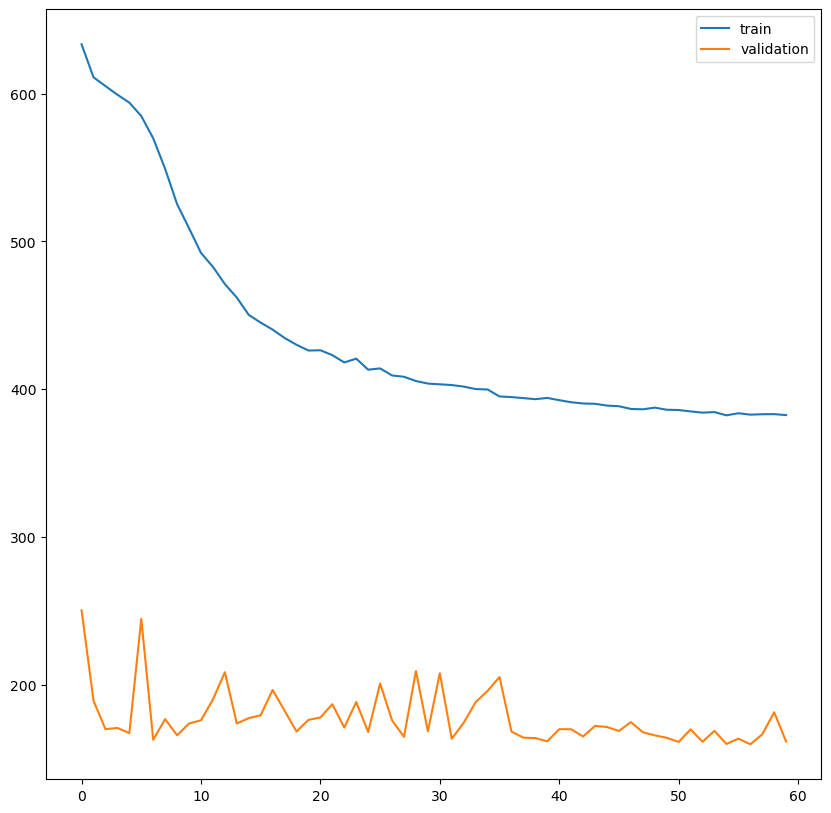

In [20]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(total_epochs),losses, label="train")
plt.plot(np.arange(total_epochs),val_losses, label="validation")
plt.legend()
plt.show()